In [1]:
import numpyro
import numpy as np
import pandas as pd
import jax.numpy as jnp

from rt_from_frequency_dynamics import discretise_gamma, discretise_lognorm, pad_delays
from rt_from_frequency_dynamics import get_standard_delays
from rt_from_frequency_dynamics import FreeGrowthModel, FixedGrowthModel, GARandomWalkModel

from rt_from_frequency_dynamics import get_location_LineageData
from rt_from_frequency_dynamics import fit_SVI_locations, MultiPosterior
from rt_from_frequency_dynamics import sample_loaded_posterior
from rt_from_frequency_dynamics import unpack_model
from rt_from_frequency_dynamics import make_path_if_absent, make_model_directories
from rt_from_frequency_dynamics import gather_R, gather_little_r, gather_ga, gather_I

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/rt-from-frequency-dynamics-bhy0OiqS-py3.9/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/rt-from-frequency-dynamics-bhy0OiqS-py3.9/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
data_name = "omicron-countries"
raw_cases = pd.read_csv(f"../data/{data_name}_location-case-counts.tsv", sep="\t")
raw_seq = pd.read_csv(f"../data/{data_name}_location-variant-sequence-counts.tsv", sep="\t")

In [3]:
# Locations to run
locations = pd.unique(raw_seq["location"])

In [4]:
# Defining Lineage Models
seed_L = 14
forecast_L = 0

# Get delays
gen = discretise_gamma(mn=5.2, std=1.72)
delays = [discretise_lognorm(mn=6.9, std=2.0)]
delays = pad_delays(delays)
    
#LM_free = FreeGrowthModel(gen, delays, seed_L, forecast_L)
#LM_fixed = FixedGrowthModel(gen, delays, seed_L, forecast_L)
LM_GARW = GARandomWalkModel(gen, delays, seed_L, forecast_L)

In [5]:
# Params for fitting
opt = numpyro.optim.Adam(step_size=1e-2)
iters = 100_000
num_samples = 3000
save = True
load = False

In [6]:
# Paths for export
path_base = f"../estimates/{data_name}"
#path_free = path_base + "/free"
#path_fixed = path_base + "/fixed"
path_GARW = path_base + "/GARW"

#make_model_directories(path_free)
#make_model_directories(path_fixed)
make_model_directories(path_GARW)

# Running models and exporting results

In [10]:
# Running free model
#MP_free = fit_SVI_locations(raw_cases, raw_seq, locations, 
#                            LM_free, opt, 
#                            iters=iters, num_samples=num_samples, save=save, load=load, path=path_free)   

In [11]:
# Running fixed model
#MP_fixed = fit_SVI_locations(raw_cases, raw_seq, locations, 
#                             LM_fixed, opt, 
#                             iters=iters, num_samples=num_samples, save=save, load=load, path=path_fixed)

In [12]:
# Running GARW model
MP_GARW = fit_SVI_locations(raw_cases, raw_seq, locations, 
                             LM_GARW, opt, 
                             iters=iters, num_samples=num_samples, save=save, load=load, path=path_GARW)

Location Australia finished (1/9).
Location Belgium finished (2/9).
Location Denmark finished (3/9).
Location Germany finished (4/9).
Location Netherlands finished (5/9).
Location South Africa finished (6/9).
Location Switzerland finished (7/9).
Location United Kingdom finished (8/9).
Location USA finished (9/9).


## Loading results

In [ ]:
# Loading past results
def load_models(rc, rs, locations, model_type, path=".", num_samples=1000):
    g, delays = get_standard_delays()
    LM = model_type(g, delays, 7, 0)
    MP = MultiPosterior()
    for i, loc in enumerate(locations):
        LD = get_location_LineageData(rc, rs, loc)
        PH = sample_loaded_posterior(LD, LM, num_samples=num_samples, path=path, name=loc)   
        MP.add_posterior(PH)
        print(f"Location {loc} finished {i+1} / {len(locations)}")
    return MP

In [ ]:
#MP_free = load_models(raw_cases, raw_seq, locations, FreeGrowthModel, path=path_free, num_samples=3000)
#MP_fixed = load_models(raw_cases, raw_seq, locations, FixedGrowthModel, path=path_fixed, num_samples=3000)

In [ ]:
MP_GARW = load_models(raw_cases, raw_seq, locations, GARandomWalkModel, path=path_GARW, num_samples=3000)

In [42]:
# Exporting growth info
ps = [0.95, 0.8, 0.5] # Which credible intevals to save

In [ ]:
# Export free model
#R_free = gather_R(MP_free, ps)
#r_free = gather_little_r(MP_free, ps, gen)
#I_free = gather_I(MP_free, ps)

#R_free.to_csv(f"{path_base}/{data_name}_Rt-combined-free.tsv", encoding='utf-8', sep='\t', index=False)
#r_free.to_csv(f"{path_base}/{data_name}_little-r-combined-free.tsv", encoding='utf-8', sep='\t', index=False)
#I_free.to_csv(f"{path_base}/{data_name}_I-combined-free.tsv", encoding='utf-8', sep='\t', index=False)

In [87]:
# Export GARW
R_GARW = gather_R(MP_GARW, ps)
r_GARW = gather_little_r(MP_GARW, ps, gen)
I_GARW = gather_I(MP_GARW, ps)

R_GARW.to_csv(f"{path_base}/{data_name}_Rt-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)
r_GARW.to_csv(f"{path_base}/{data_name}_little-r-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)
I_GARW.to_csv(f"{path_base}/{data_name}_I-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)

In [44]:
# Export fixed model
#R_fixed = gather_R(MP_fixed, ps)
#r_fixed = gather_little_r(MP_fixed, ps, gen)
#ga_fixed = gather_ga(MP_fixed, ps, rel_to="Delta")
#I_fixed = gather_I(MP_fixed, ps)

#R_fixed.to_csv(f"{path_base}/{data_name}_Rt-combined-fixed.tsv", encoding='utf-8', sep='\t', index=False)
#r_fixed.to_csv(f"{path_base}/{data_name}_little-r-combined-fixed.tsv", encoding='utf-8', sep='\t', index=False)
#ga_fixed.to_csv(f"{path_base}/{data_name}_ga-combined-fixed.tsv", encoding='utf-8', sep='\t', index=False)
#I_fixed.to_csv(f"{path_base}/{data_name}_I-combined-fixed.tsv", encoding='utf-8', sep='\t', index=False)

# Making figures

In [45]:
# Figures for export
path_fig = path_base + "/figures"
make_path_if_absent(path_fig)

In [46]:
from rt_from_frequency_dynamics.plotfunctions import *
ps = DefaultAes.ps
alphas = DefaultAes.alphas
v_colors = ["#56e39f", "#9932CC", "#808080"]
v_names = ['Delta', 'Omicron', 'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [47]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [48]:
# What to output?

In [49]:
10 // 3

3

In [63]:
# Variant frequencies for each location from free R model
def posterior_frequencies_by_country(MP, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
        
    size = 8
    n_per_row = 3
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(1.5*n_per_row*size, n_rows*size))
    gs = fig.add_gridspec(nrows=n_rows, ncols= n_per_row)
    
    ax_list = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        ax = fig.add_subplot(gs[this_row, this_col])
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        plot_posterior_frequency(ax, dataset, ps, alphas, colors, forecast=False)
        plot_observed_frequency(ax, LD, colors)
        add_dates_sep(ax, LD.dates, sep=14)
        ax.set_title(loc)
        if this_col == 0:
            ax.set_ylabel("Variant frequency")
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return fig

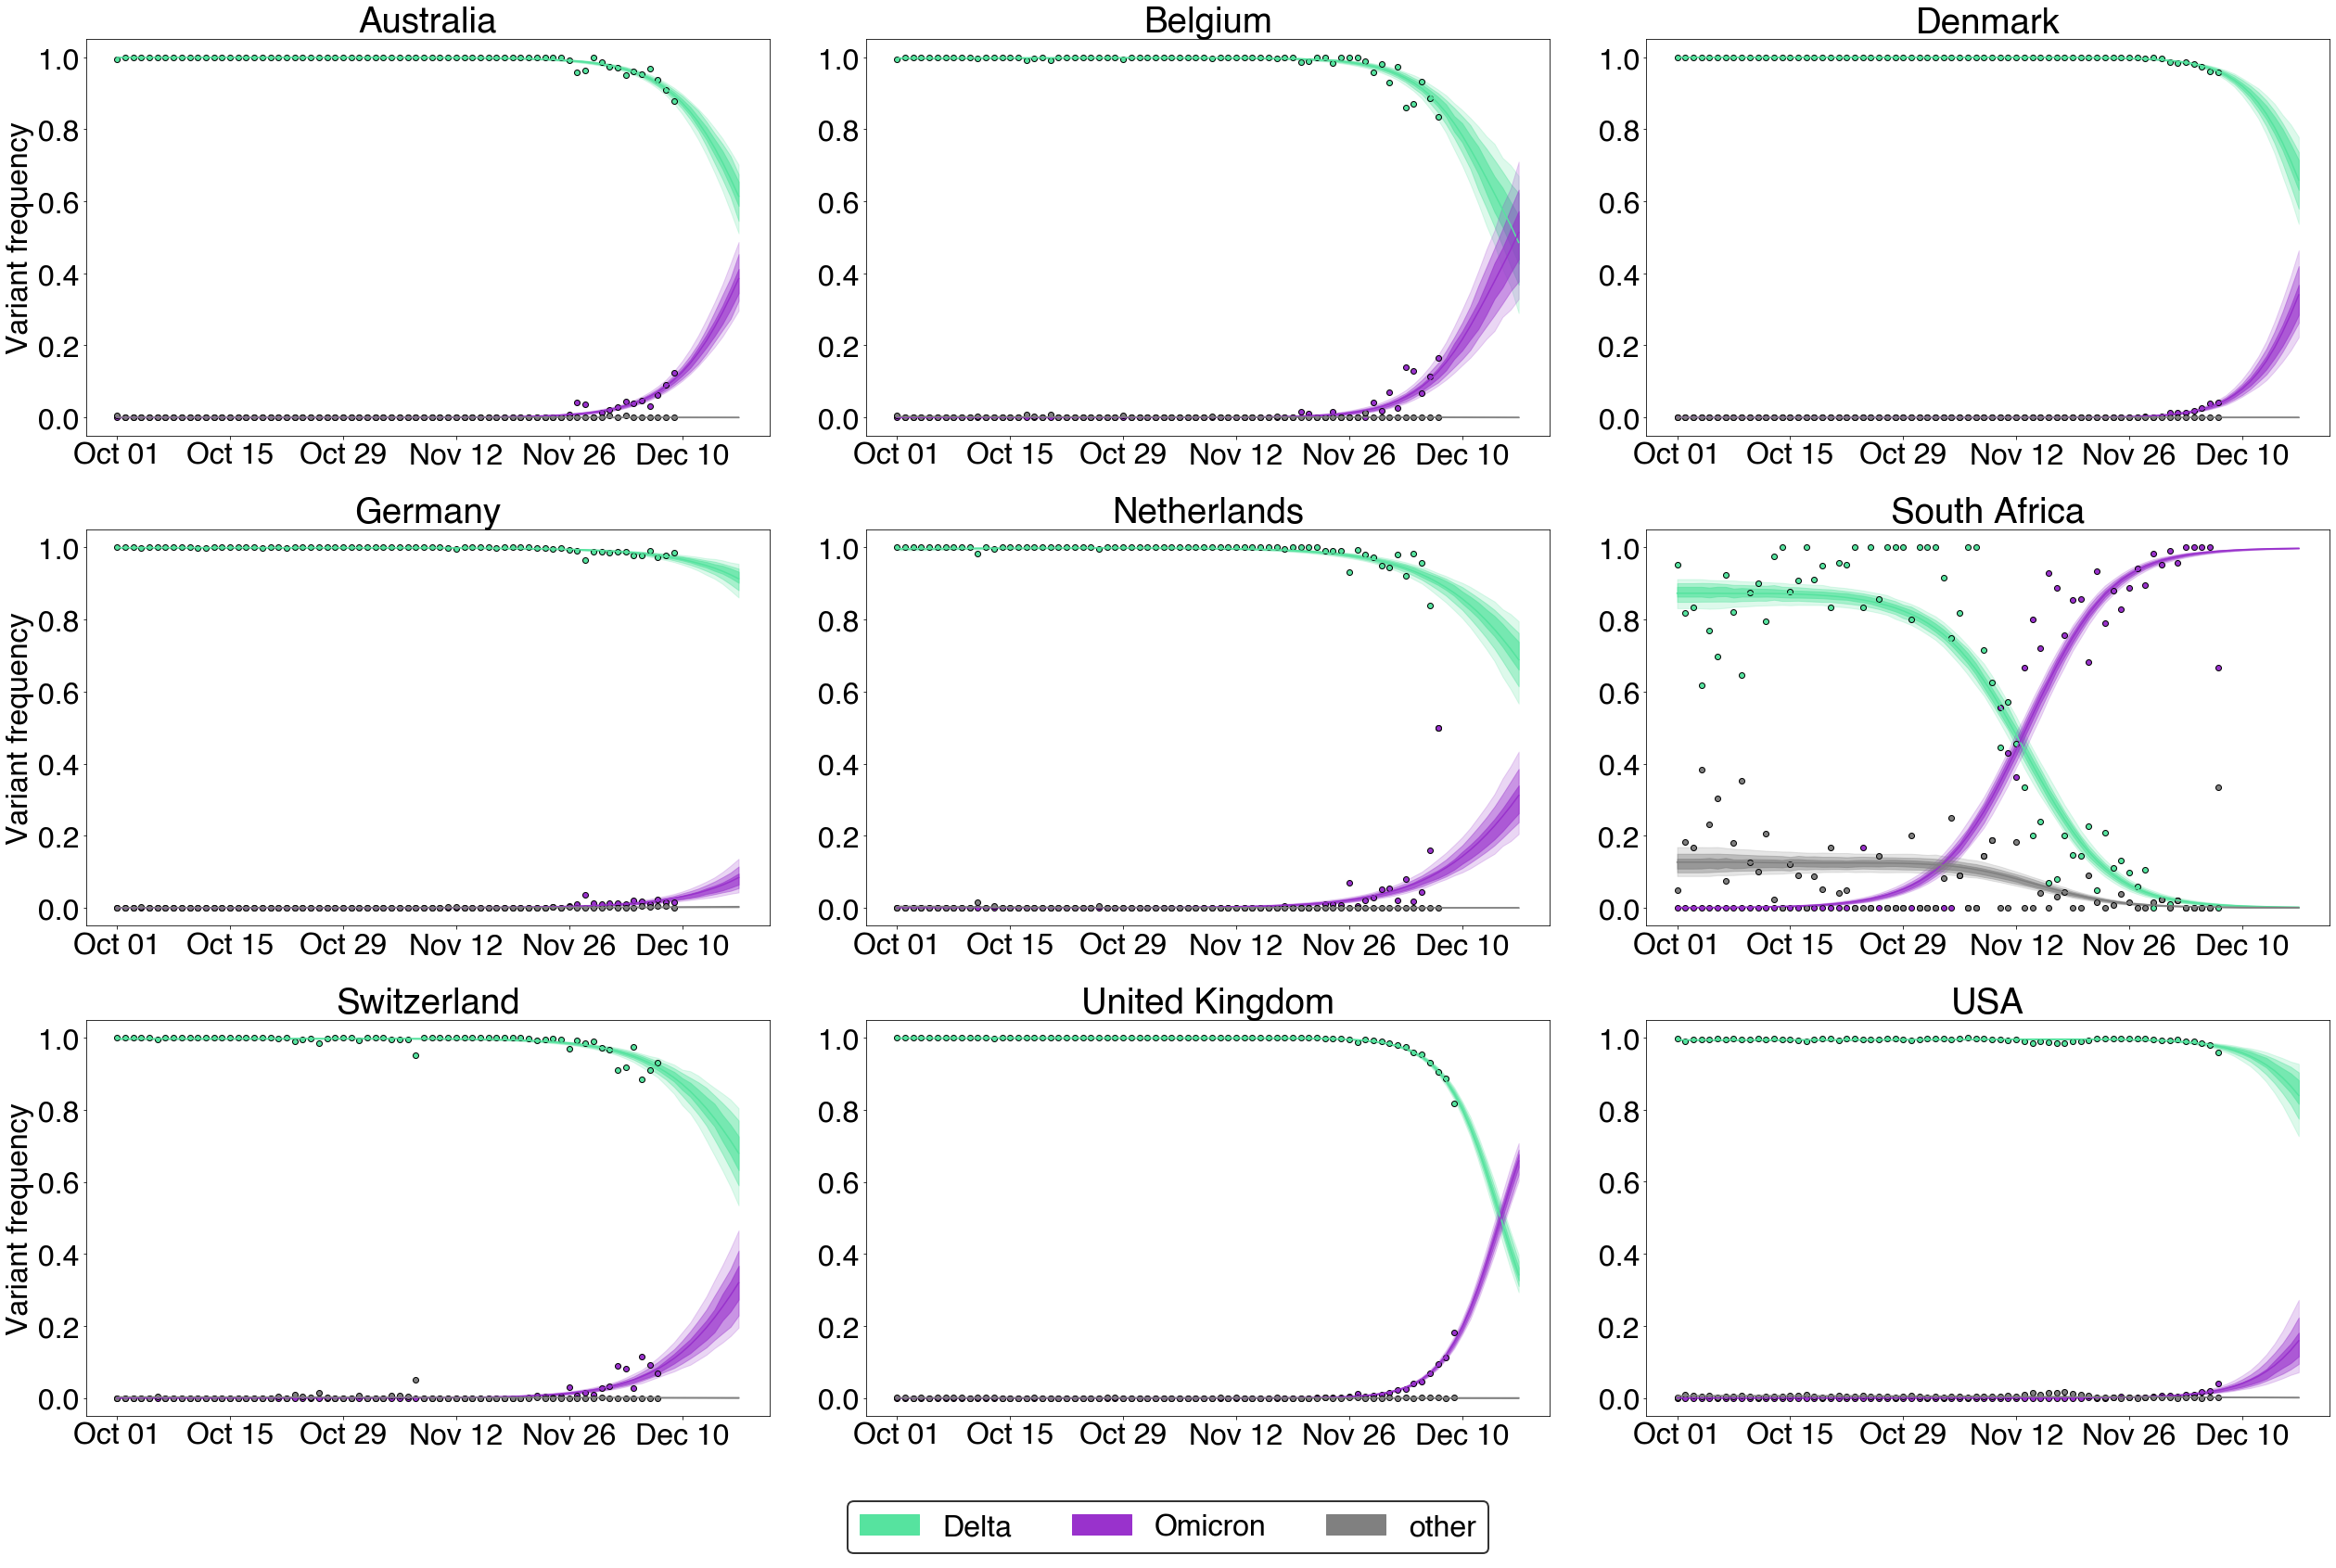

In [64]:
fig_freq = posterior_frequencies_by_country(MP_GARW, ps, alphas, color_map)

In [73]:
# Case counts partitioned by variant
# Effective reproductive number estimates by country
def posterior_cases_R_by_country(MP, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)

    size = 8
    n_per_row = 3
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(2.0*n_per_row*size, 1.4*n_rows*size))
    gs = fig.add_gridspec(nrows=2*n_rows, ncols= n_per_row, height_ratios=[1.5,1] * n_rows)

    ax_list_cases = []
    ax_list_R = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        
        # Create axes
        if i == 0:
            ax_cases = fig.add_subplot(gs[2*this_row,this_col])
            ax_R = fig.add_subplot(gs[2*this_row+1,this_col])
        else:
            ax_cases = fig.add_subplot(gs[2*this_row,this_col])
            ax_R = fig.add_subplot(gs[2*this_row+1,this_col]) #, sharey = ax_list_R[0])
            
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        # Plot cases and posterior lineage I
        plot_cases(ax_cases, LD)
        plot_posterior_I(ax_cases, dataset, ps, alphas, colors)
        add_dates_sep(ax_cases, LD.dates, sep = 14)

        # Plot posterior R valuse
        plot_R_censored(ax_R, dataset, ps, alphas, colors, thres=0.001)
        add_dates_sep(ax_R, LD.dates, sep = 14)
        ax_cases.set_title(loc)

        
        if this_col == 0:
            ax_cases.set_ylabel("Variant cases")
            ax_R.set_ylabel("Variant Rt")
            
        ax_list_cases.append(ax_cases)
        ax_list_R.append(ax_R)
        
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1) 
    return fig

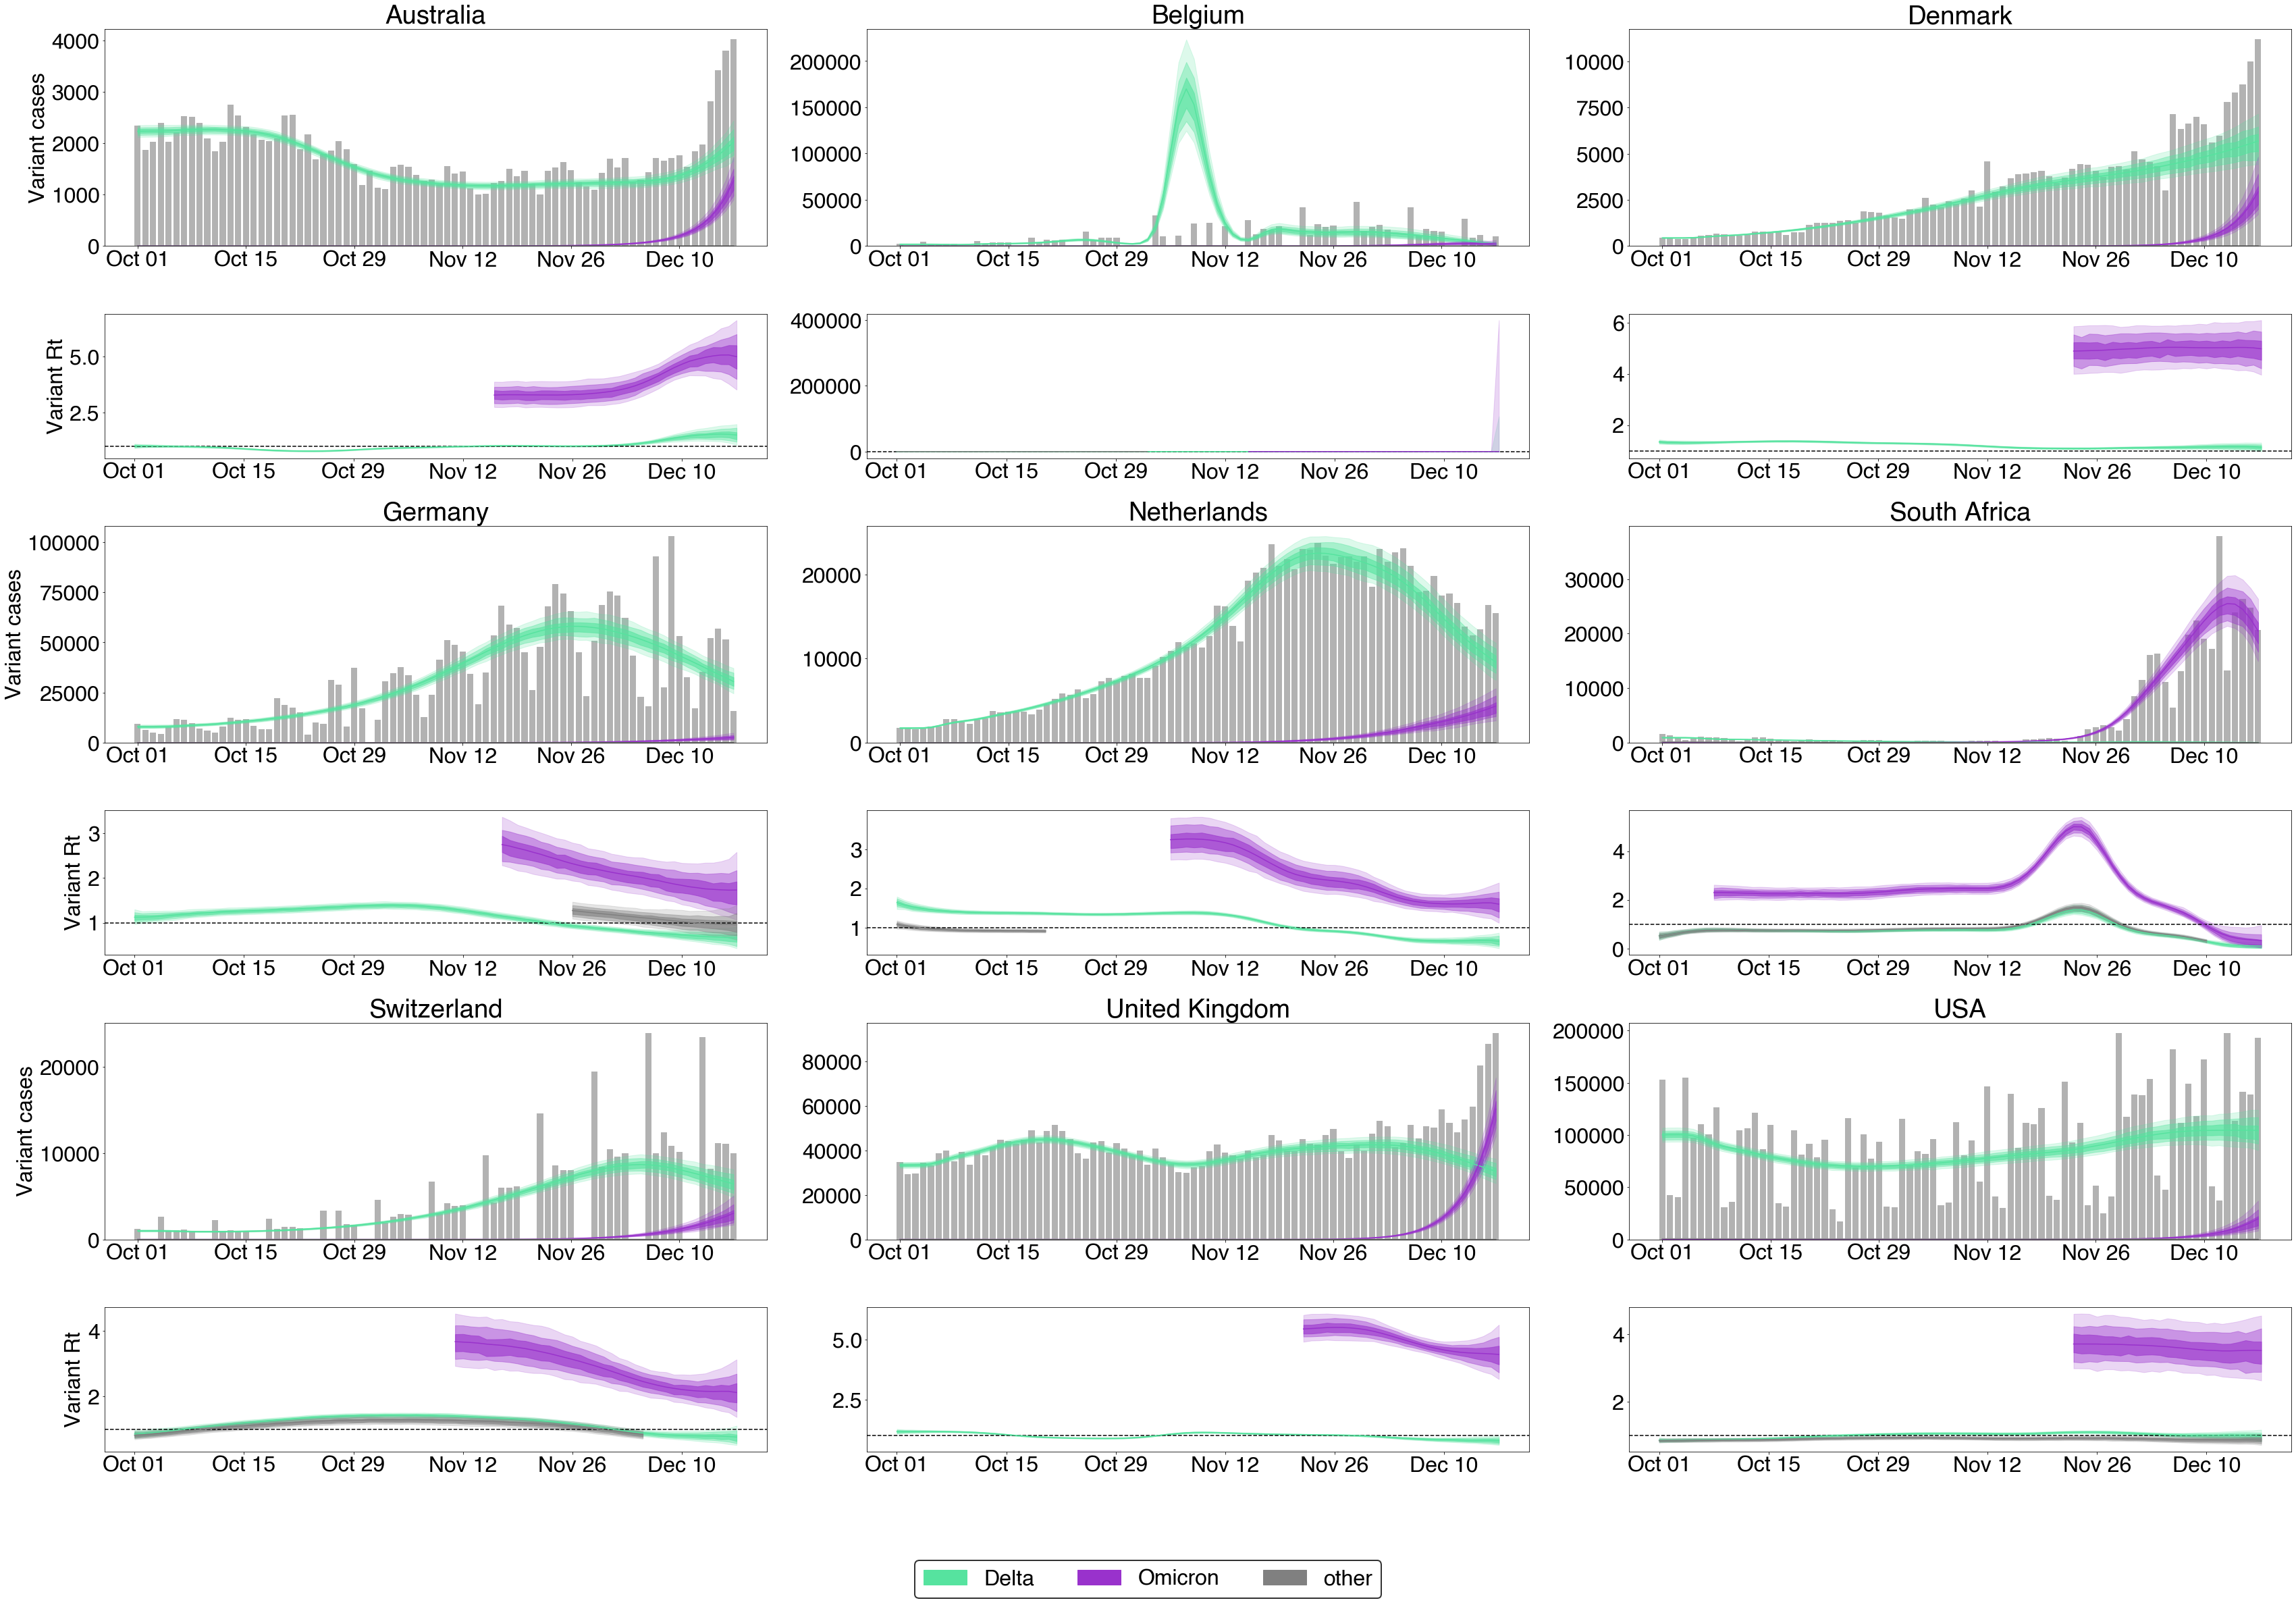

In [74]:
fig_case_R = posterior_cases_R_by_country(MP_GARW, ps, alphas, color_map);

# Growth rates by variant by country

In [82]:
def posterior_cases_epidemic_gr_by_country(MP, g, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
    
    size = 8
    n_per_row = 3
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(2.2*n_per_row*size, 1.5*n_rows*size))
    gs = fig.add_gridspec(nrows=2*n_rows, ncols= n_per_row, height_ratios=[1.5,1] * n_rows)
    
    ax_list_cases = []
    ax_list_r = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        
        # Create axes
        if i == 0:
            ax_cases = fig.add_subplot(gs[2*this_row,this_col])
            ax_r = fig.add_subplot(gs[2*this_row+1,this_col])
        else:
            ax_cases = fig.add_subplot(gs[2*this_row,this_col])
            ax_r = fig.add_subplot(gs[2*this_row+1,this_col])#, sharey = ax_list_r[0])
            
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        # Plot cases and posterior lineage I
        plot_cases(ax_cases, LD)
        plot_posterior_I(ax_cases, dataset, ps, alphas, colors)
        add_dates_sep(ax_cases, LD.dates, sep=14)
        ax_cases.set_title(loc)

        # Plot posterior little r values
        plot_little_r_censored(ax_r, dataset, g, ps, alphas, colors, thres=0.001)
        add_dates_sep(ax_r, LD.dates, sep=14)
        
        
        if i == 0:
            ax_cases.set_ylabel("Variant cases")
            ax_r.set_ylabel("Epidemic growth rate")
            
        ax_list_cases.append(ax_cases)
        ax_list_r.append(ax_r)

    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1) 
    return fig

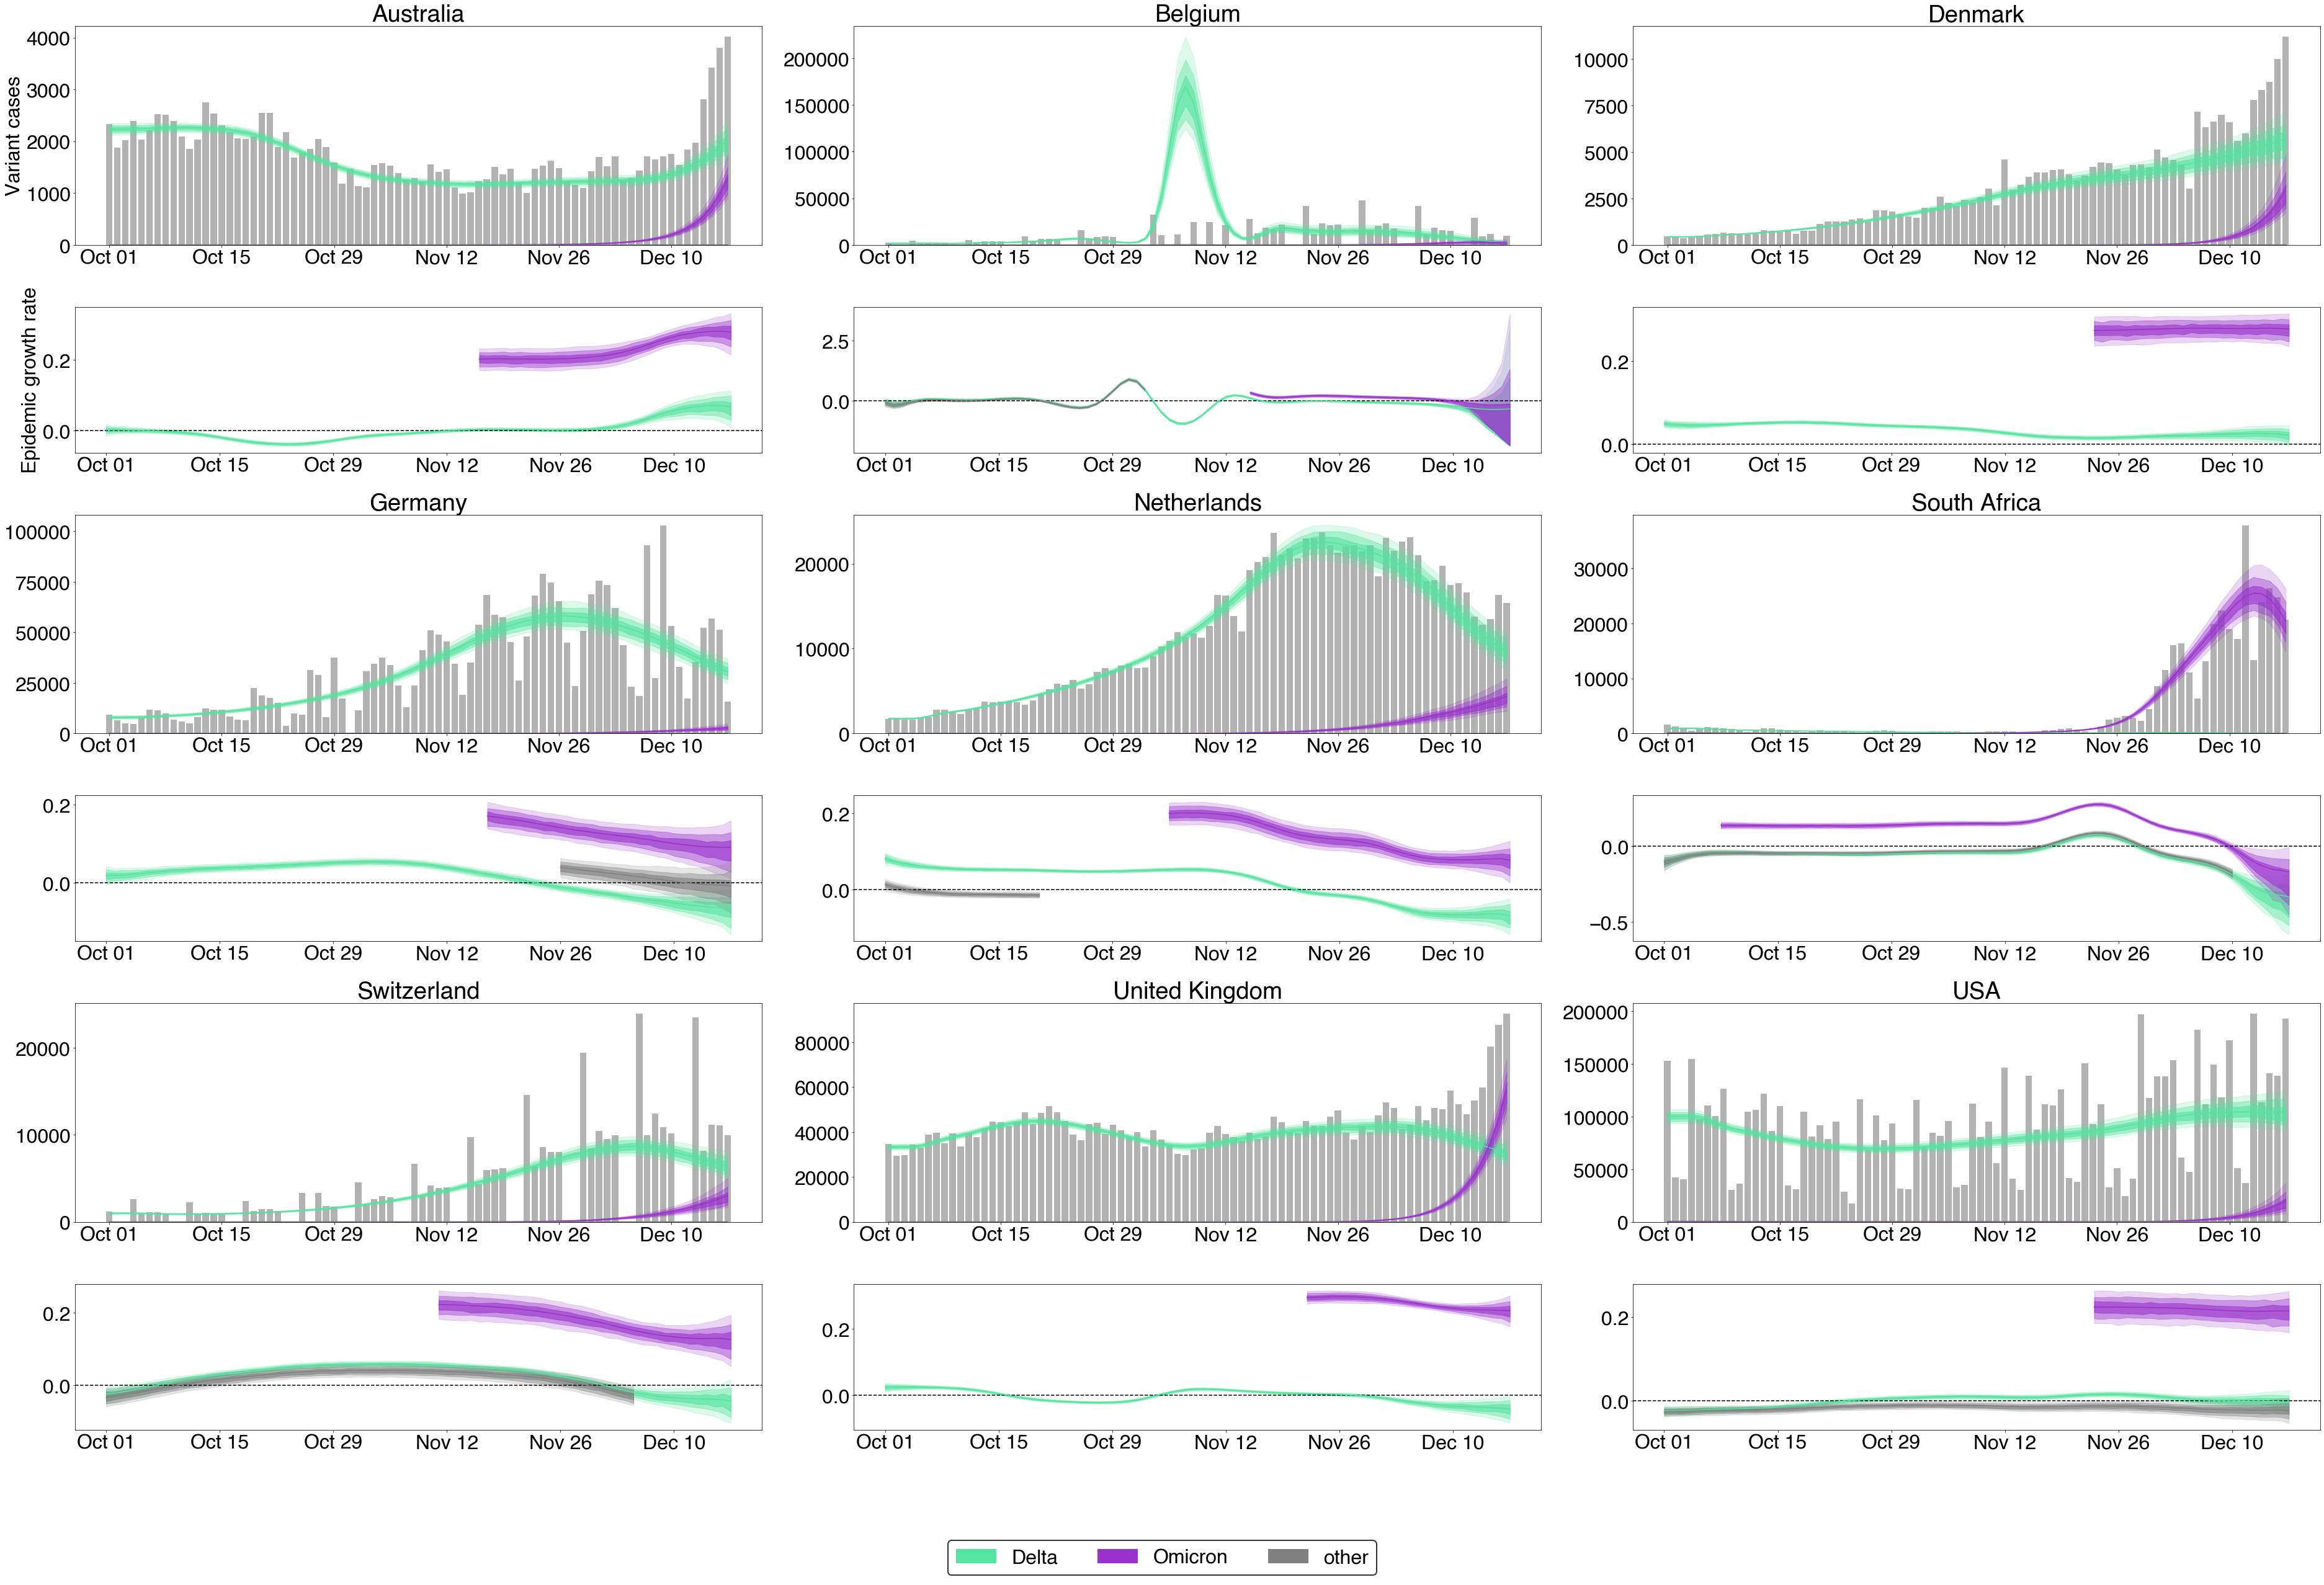

In [83]:
fig_case_r = posterior_cases_epidemic_gr_by_country(MP_GARW, gen, ps, alphas, color_map);

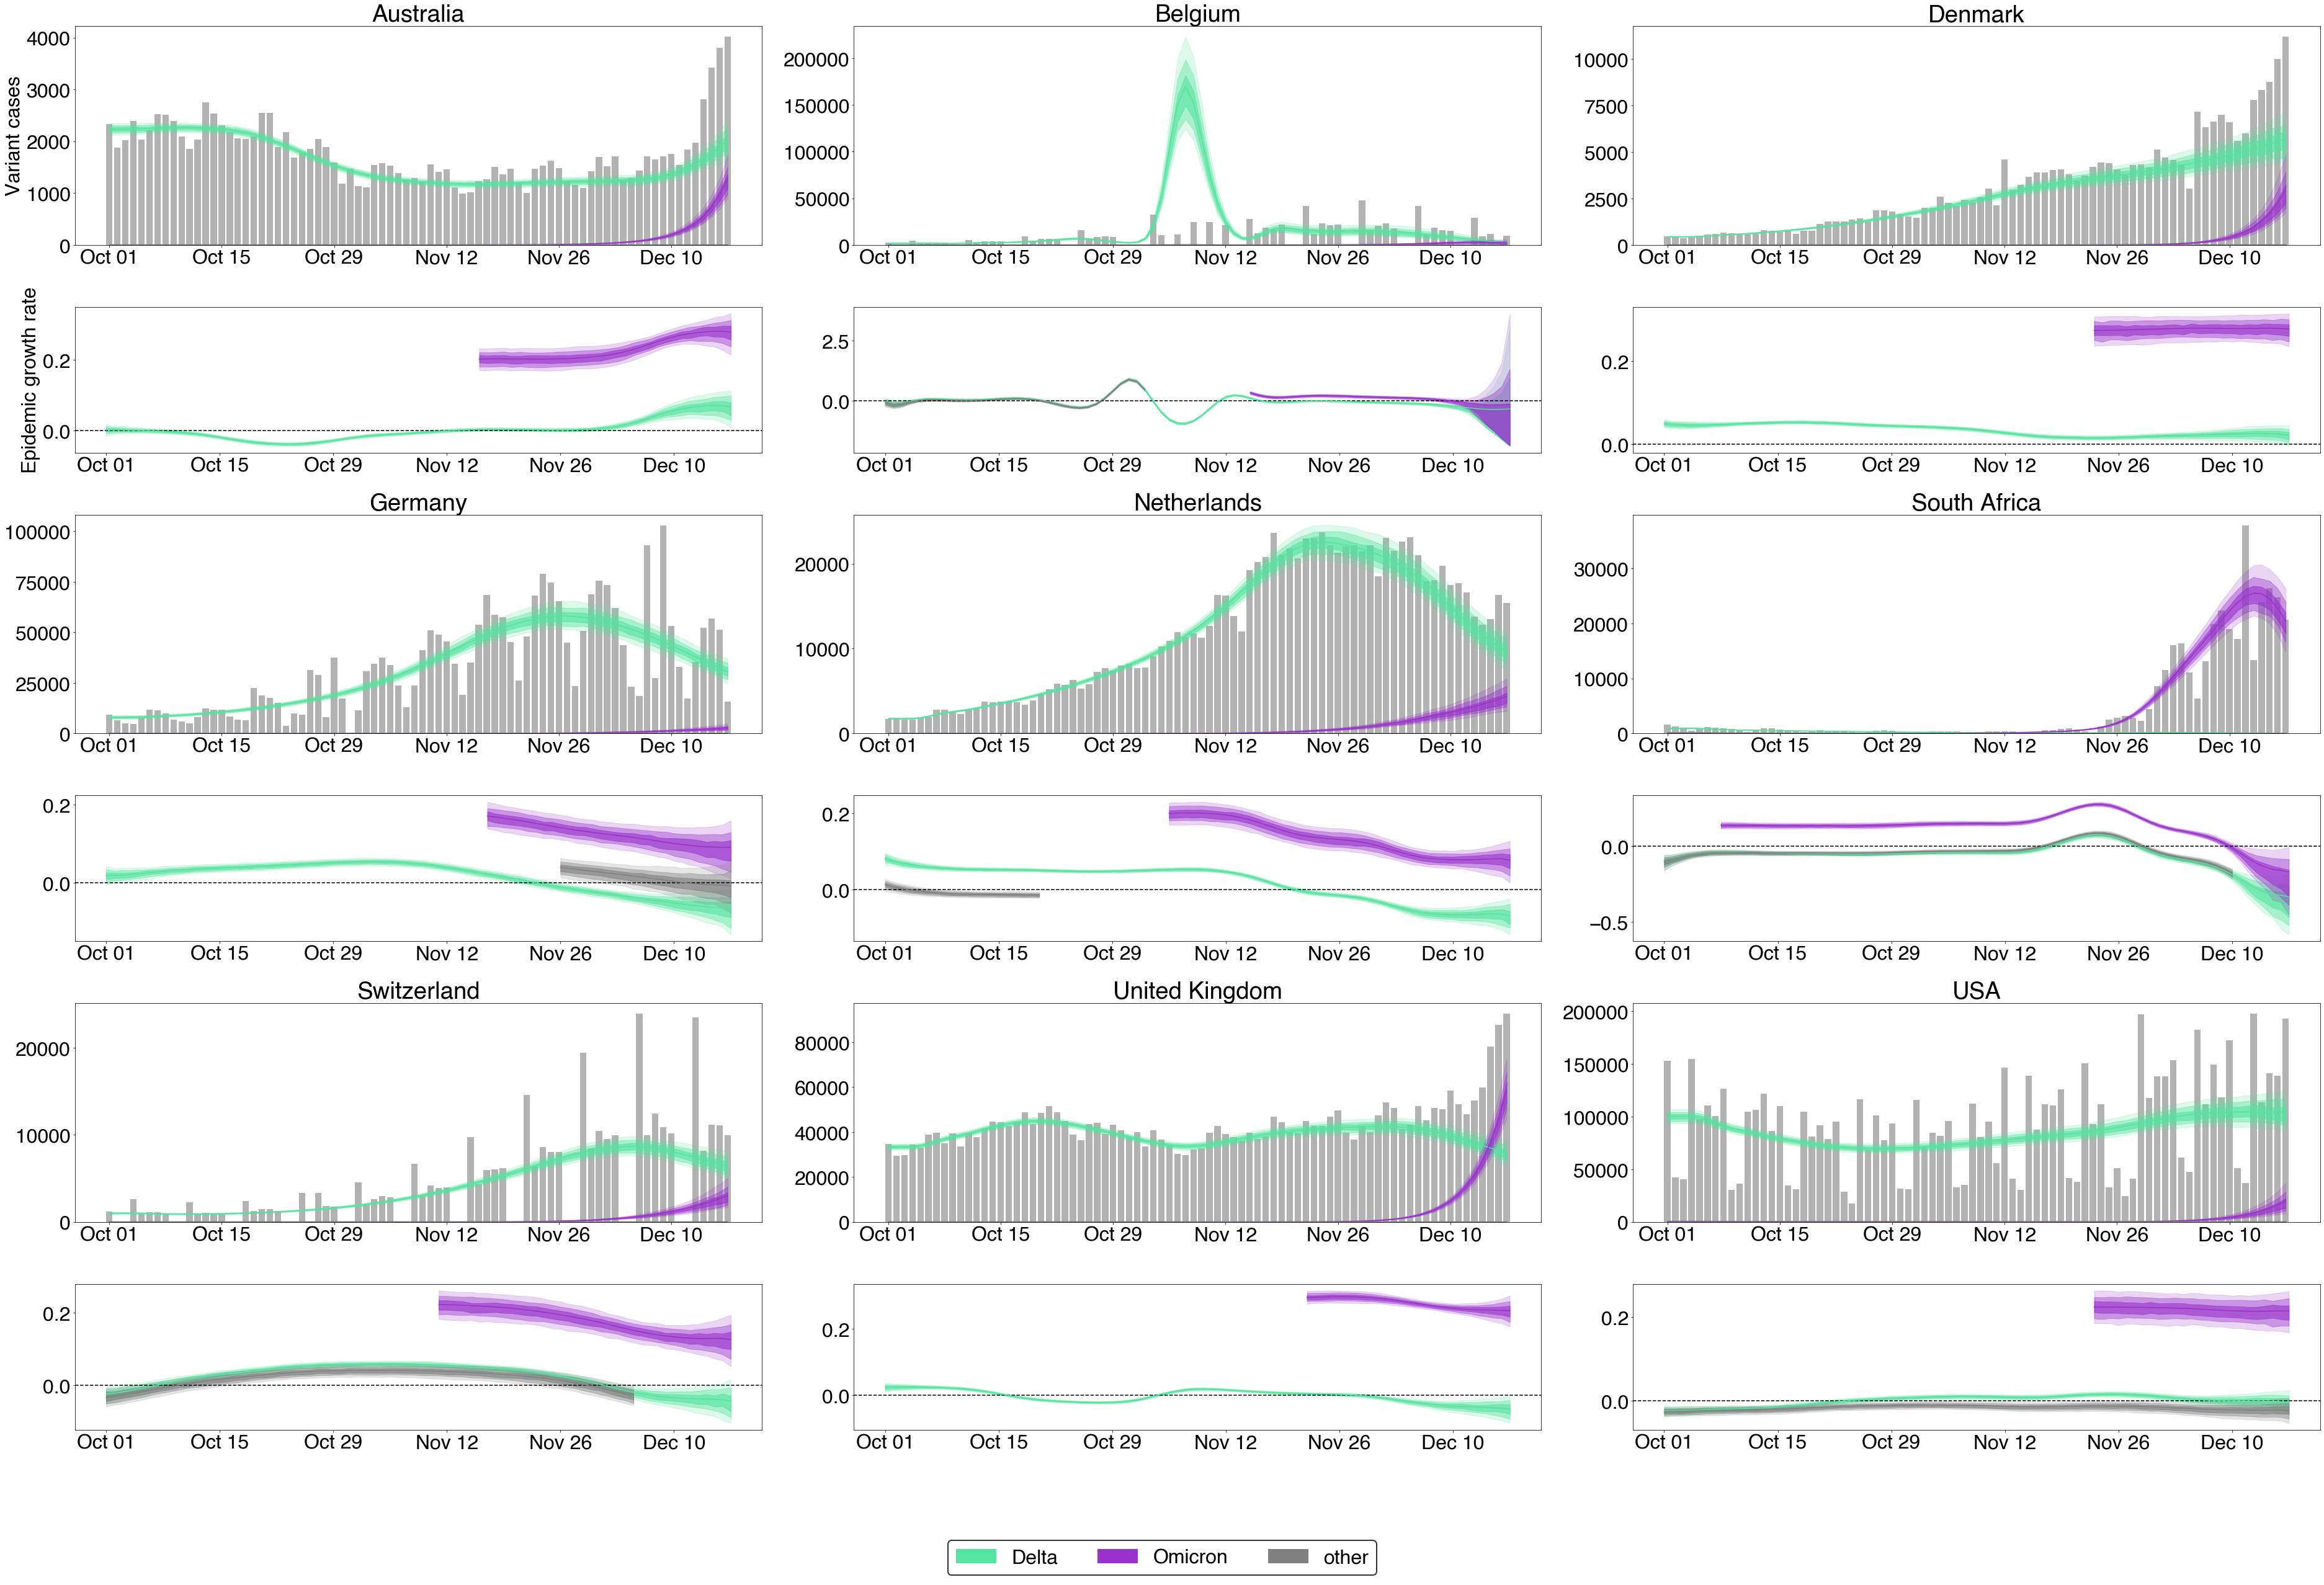

In [84]:
fig_case_r

# Saving figures


In [85]:
#model_names = ["free", "fixed"]
#model_posterior = [MP_free, MP_fixed]

model_names = ["GARW"]
model_posterior = [MP_GARW]

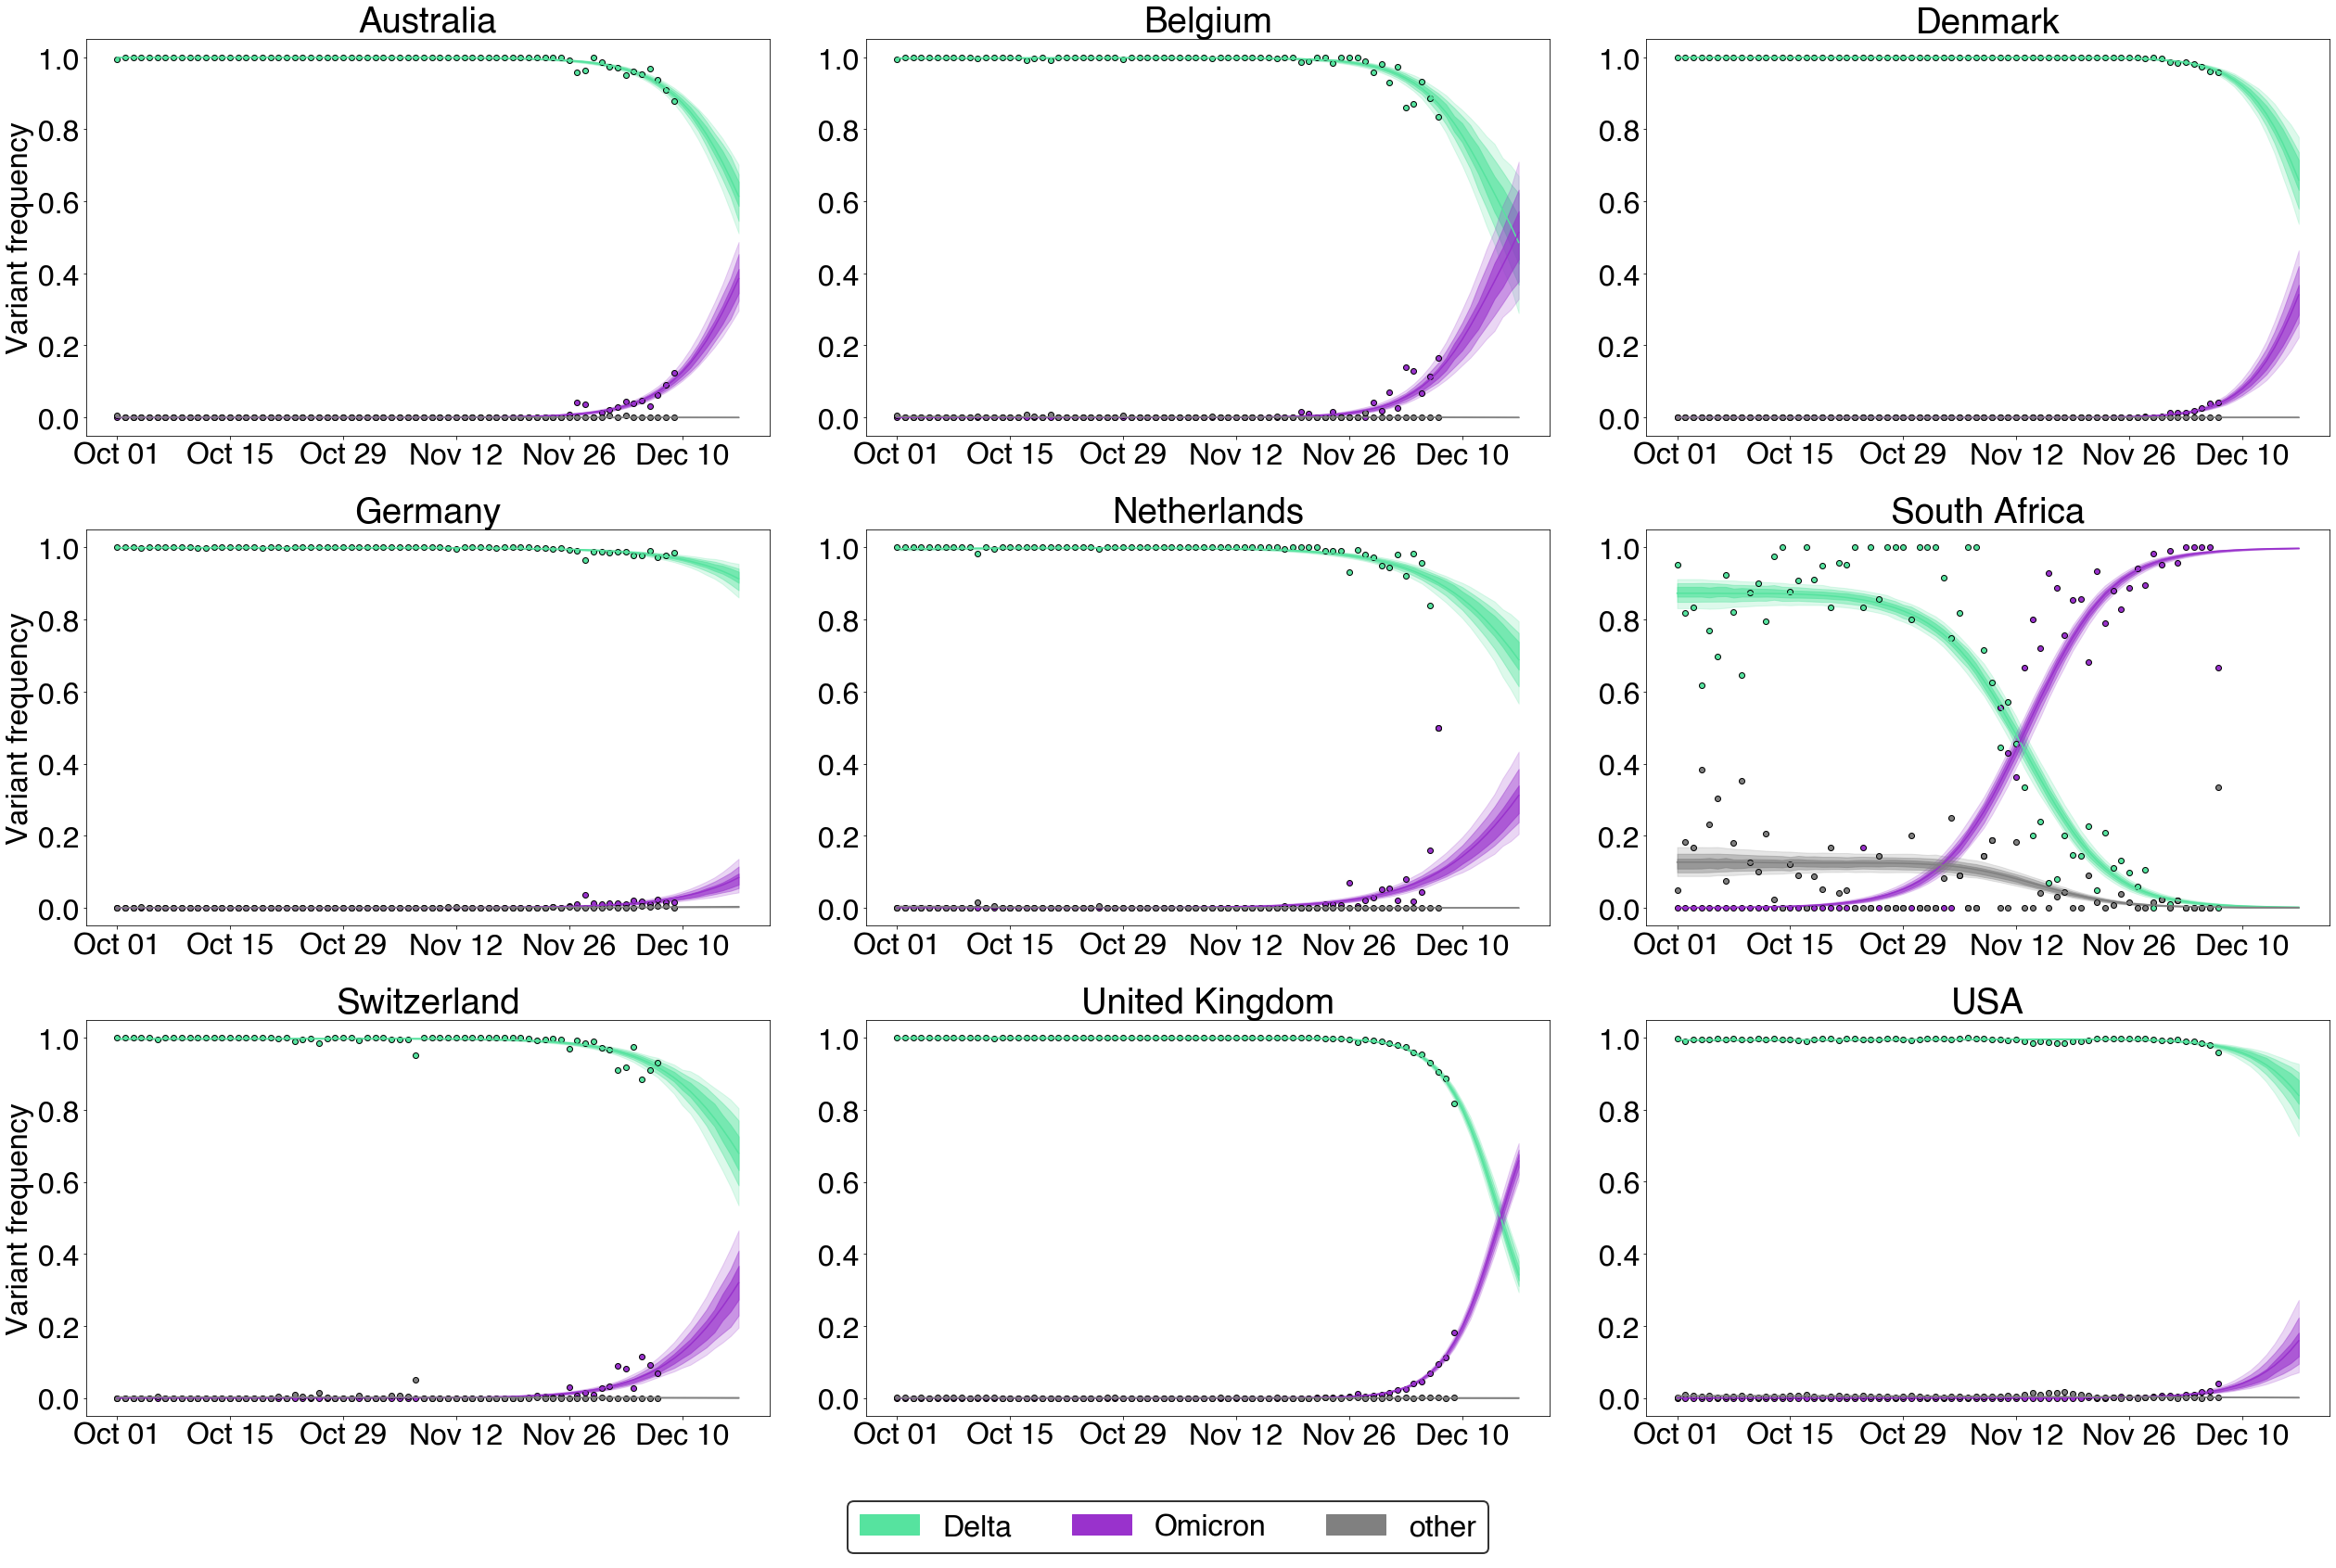

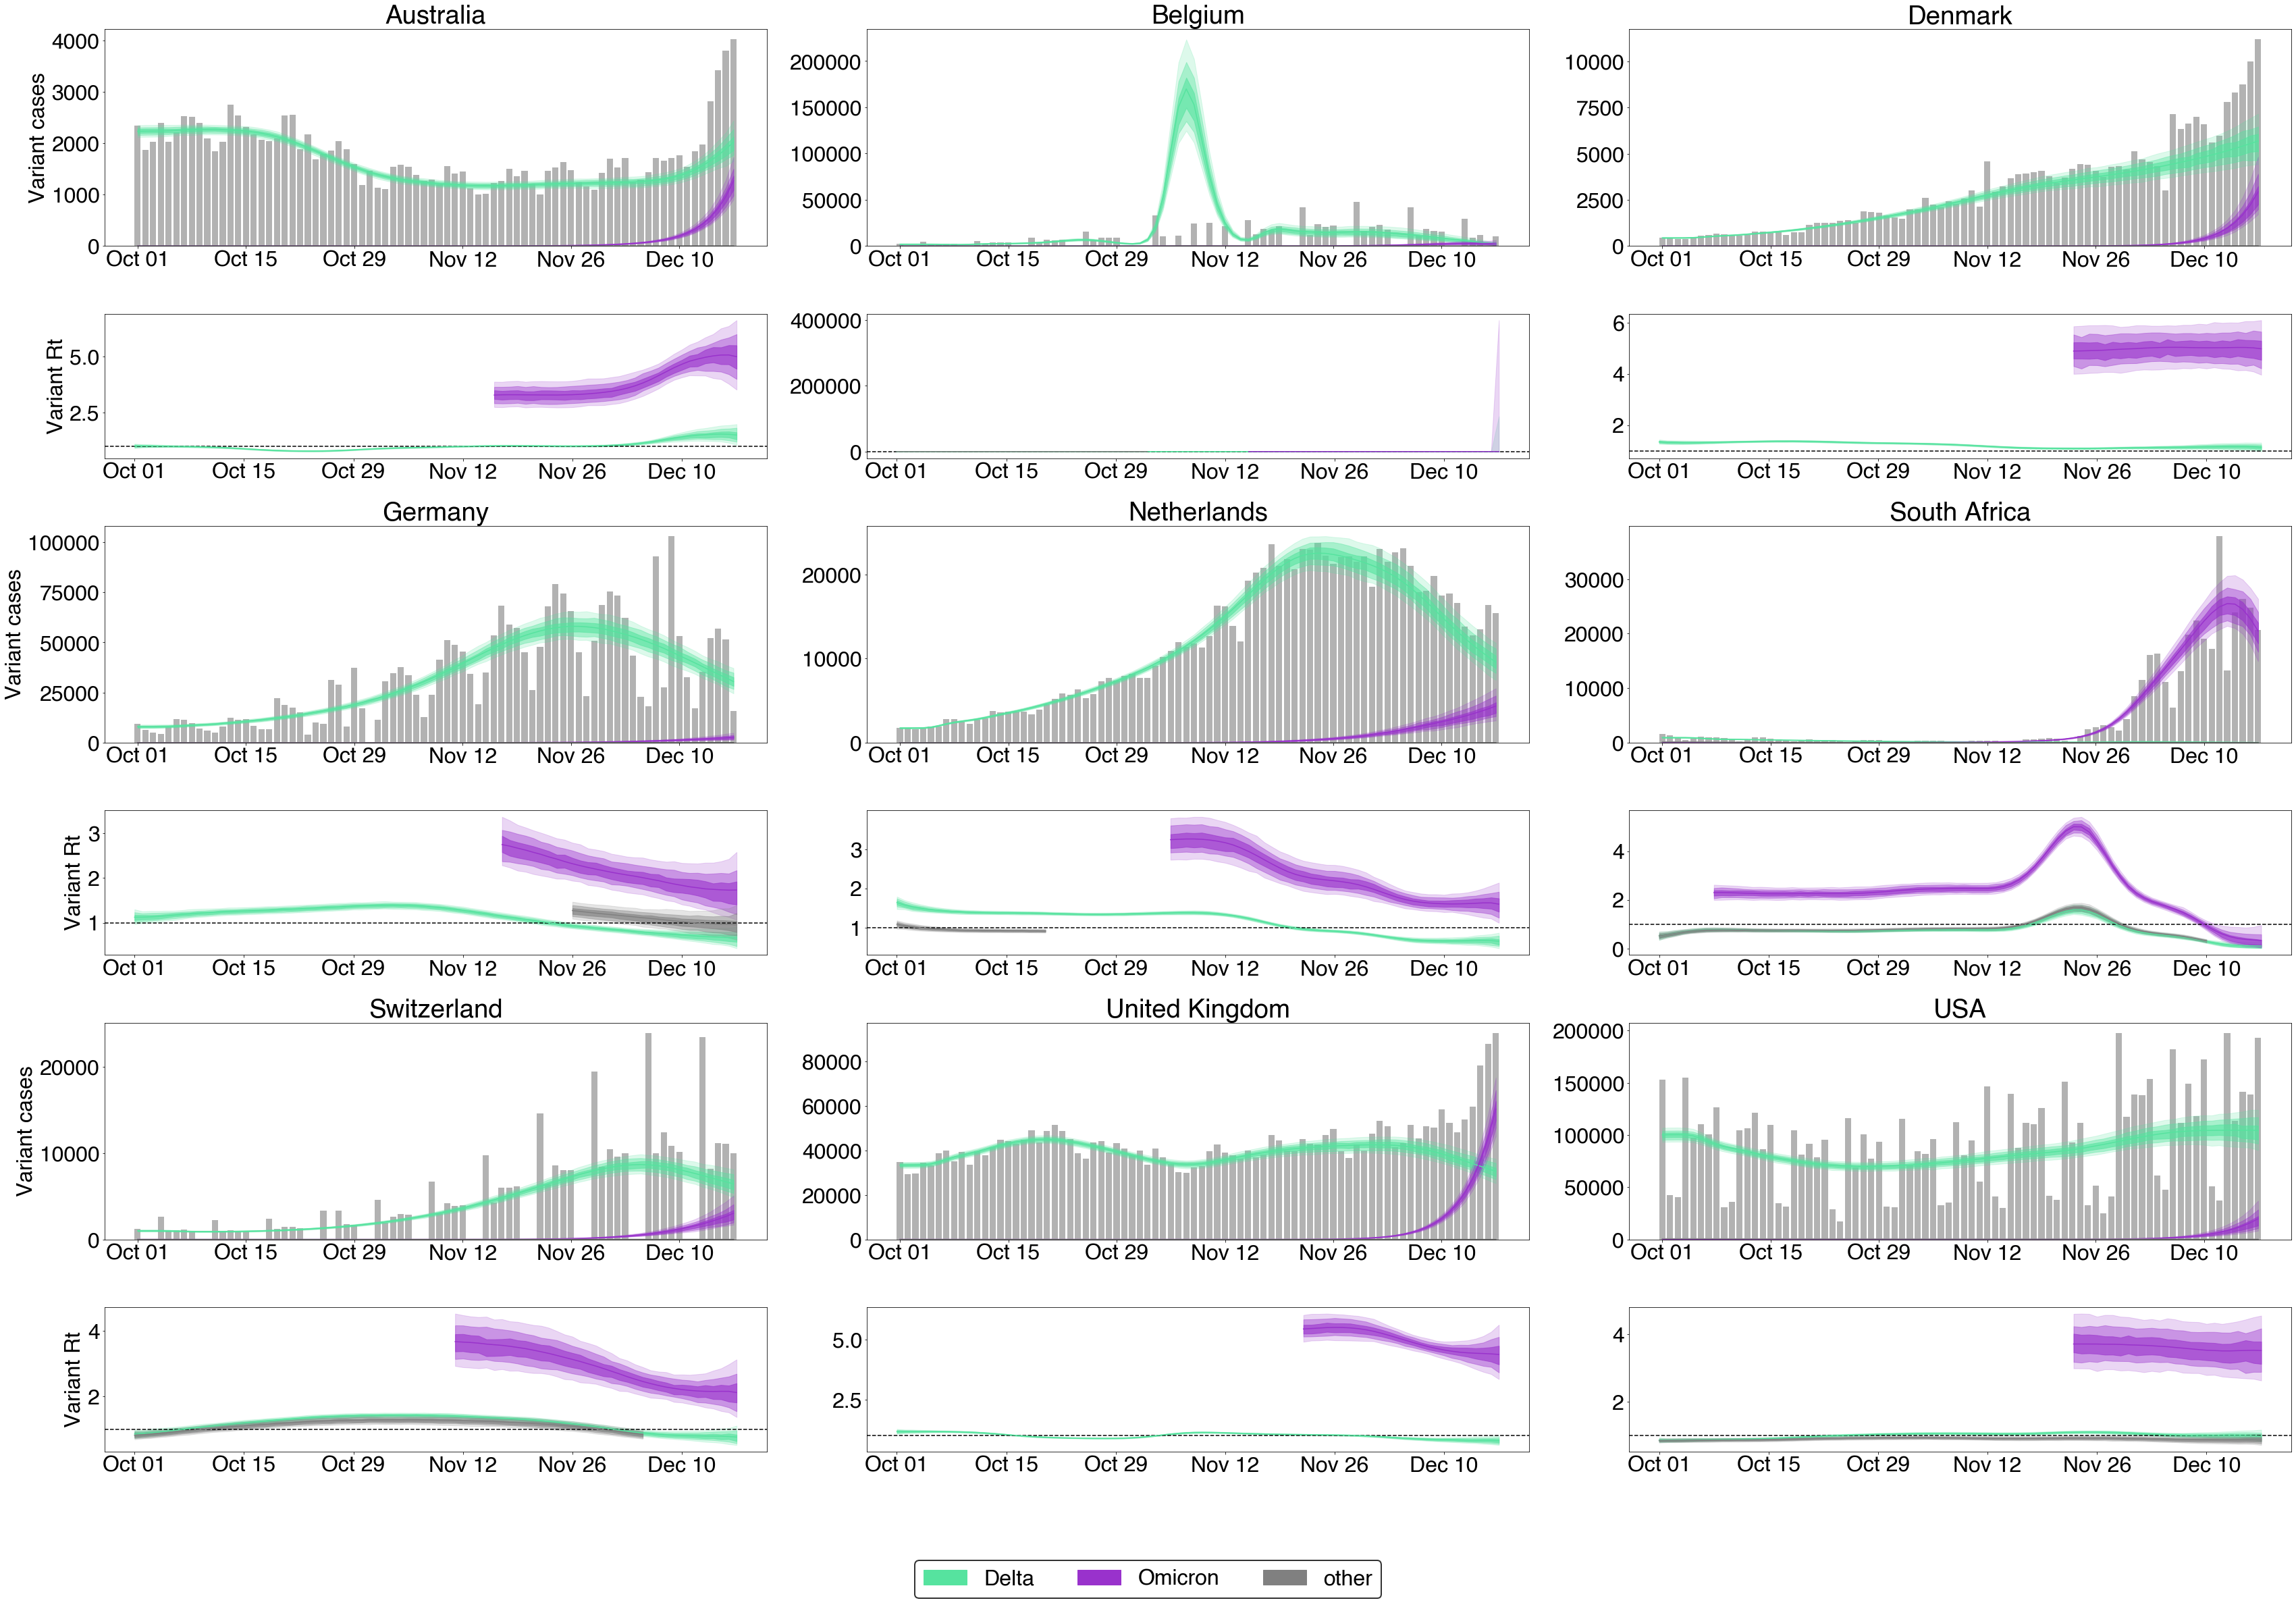

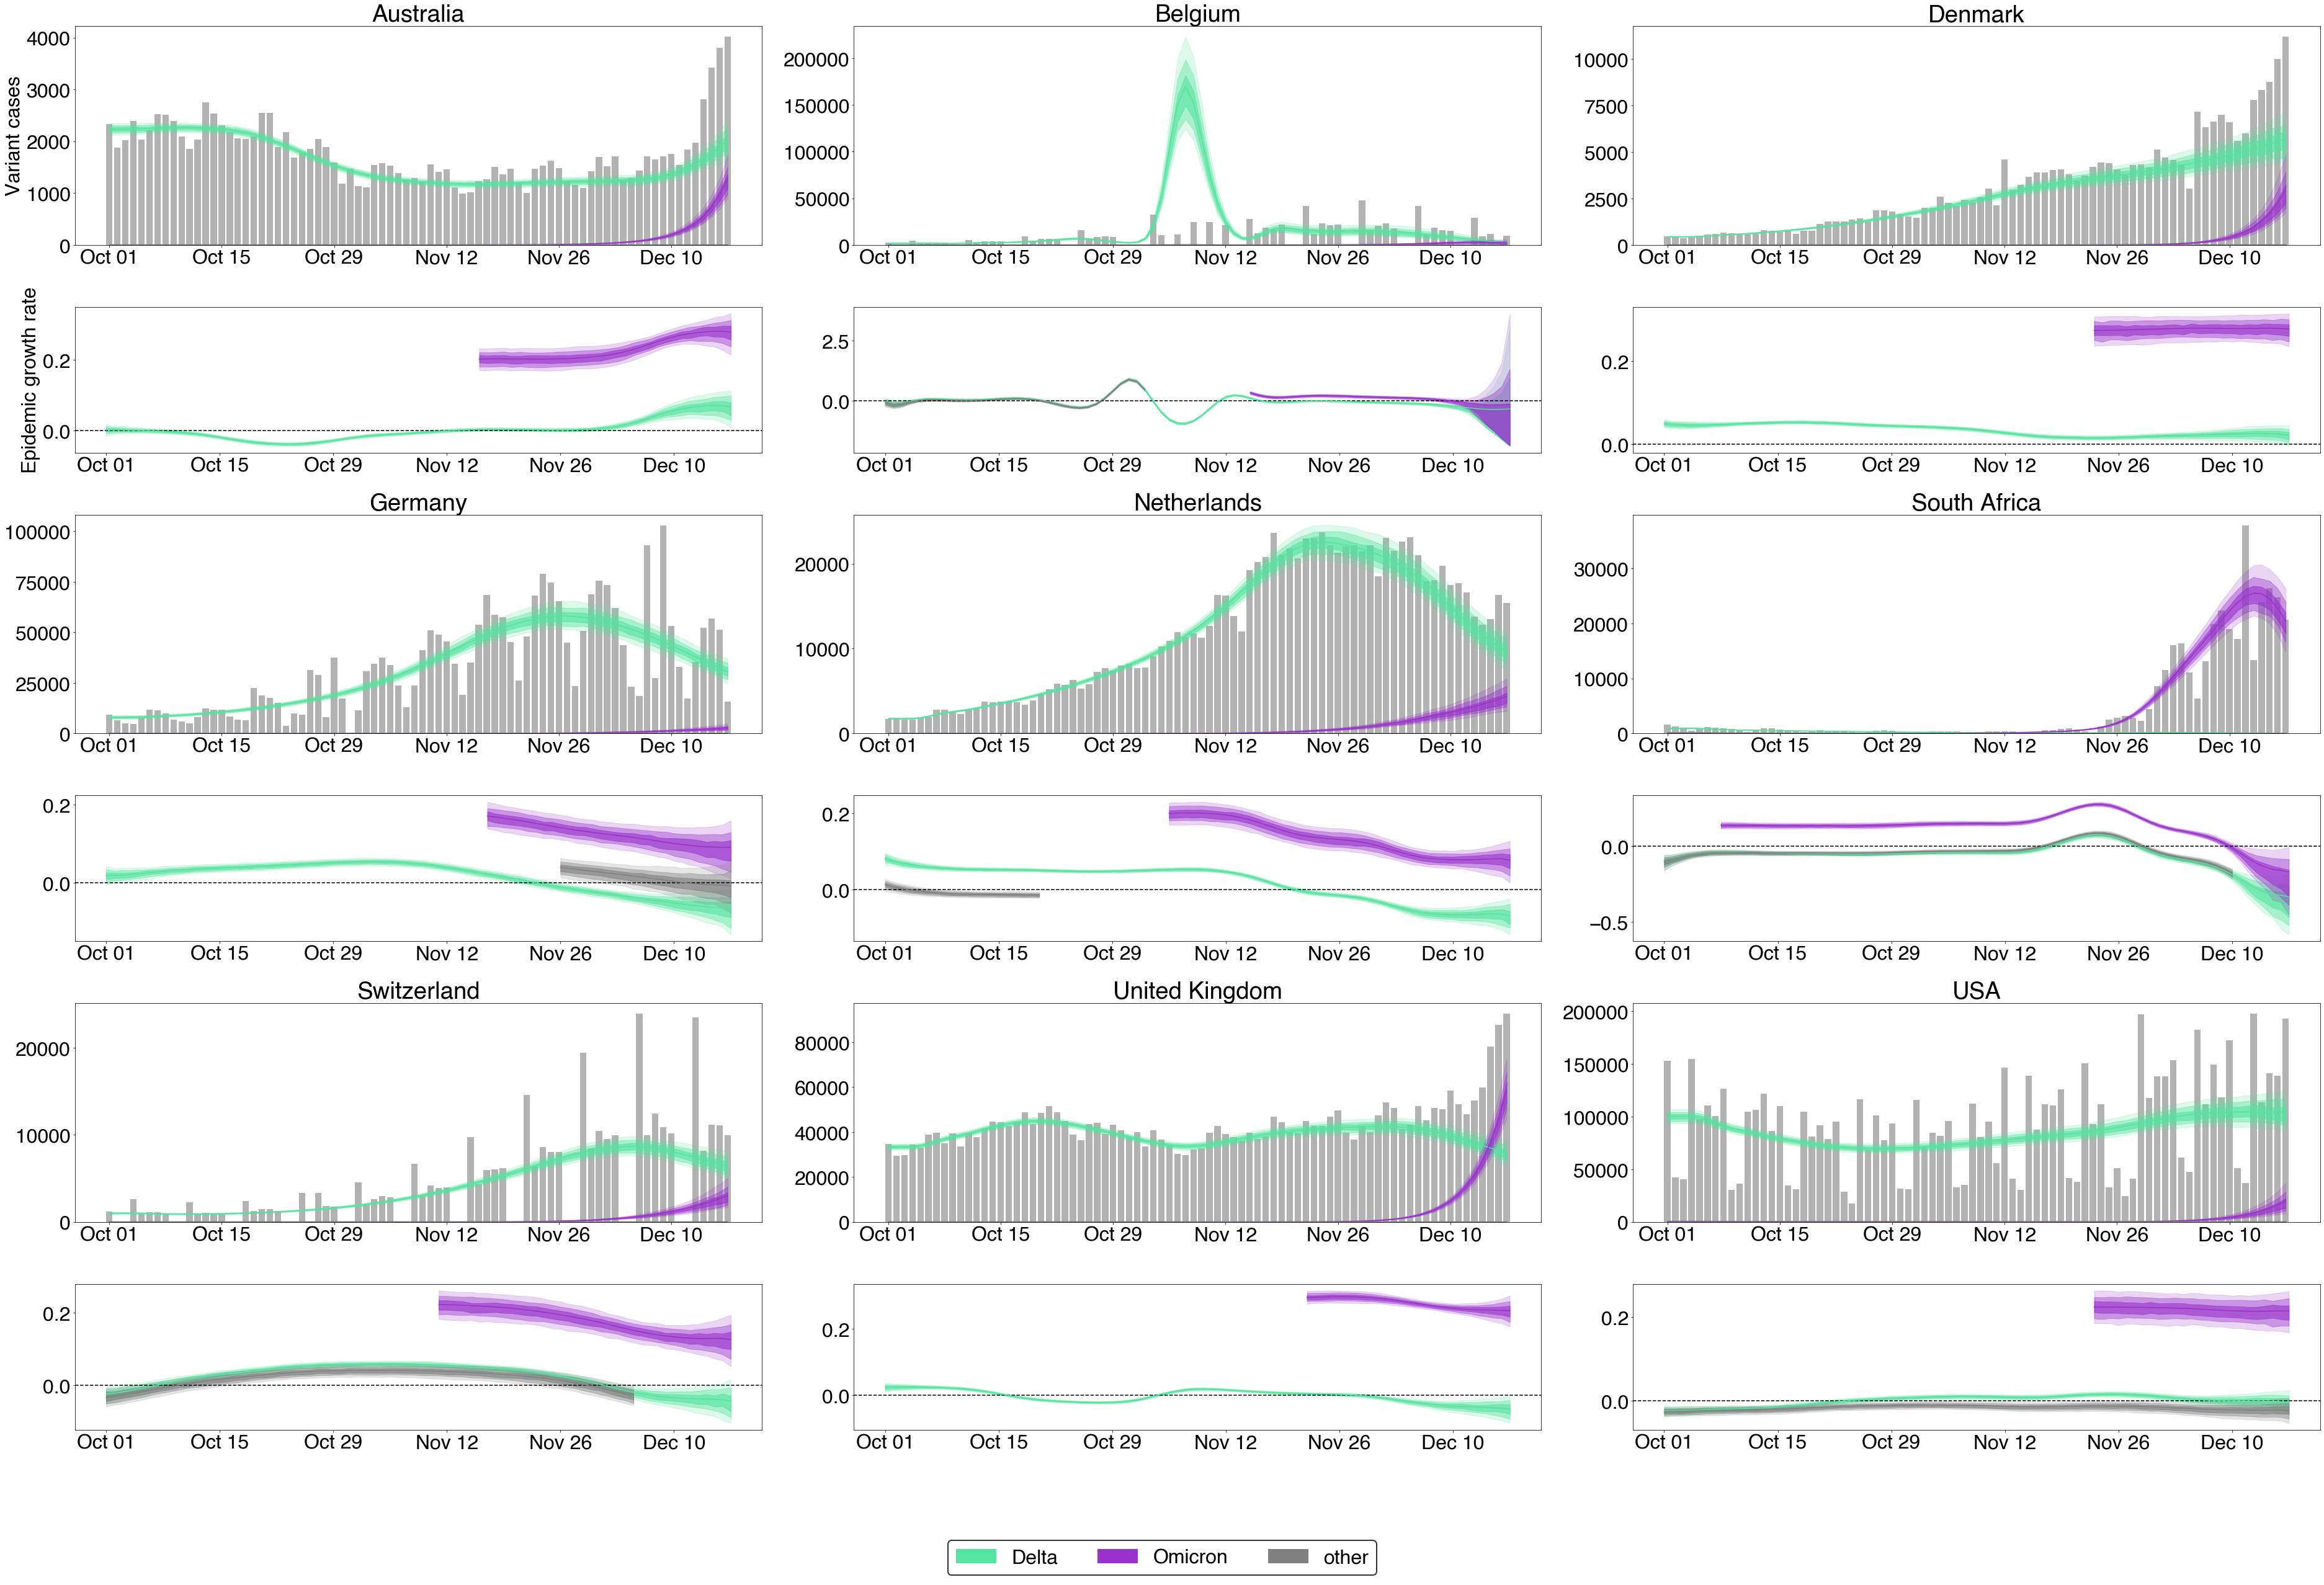

In [86]:
for mname, MP in zip(model_names, model_posterior):
    fig_freq = posterior_frequencies_by_country(MP, ps, alphas, color_map);
    fig_case_R = posterior_cases_R_by_country(MP, ps, alphas, color_map);
    fig_case_r = posterior_cases_epidemic_gr_by_country(MP, gen, ps, alphas, color_map);
    
    # Export figures
    fig_freq.savefig(f"{path_fig}/{data_name}_frequency-estimates-{mname}.png", facecolor="w", bbox_inches='tight')
    fig_case_R.savefig(f"{path_fig}/{data_name}_cases-R-estimates-{mname}.png", facecolor="w", bbox_inches='tight')
    fig_case_r.savefig(f"{path_fig}/{data_name}_cases-little-r-estimates-{mname}.png", facecolor="w", bbox_inches='tight')

# Growth advantages by variant by country

In [ ]:
ga_df = pd.read_csv(f"{path_base}/{data_name}_ga-combined-fixed.tsv", sep = "\t")

In [ ]:
def figure_growth_advantage(ga_df, ps, alphas, color_map):
    fig = plt.figure(figsize=(12, 20))
  
    variants = pd.unique(ga_df.variant)
    colors = [color_map[v] for v in variants]
    locations = pd.unique(ga_df.location)
    location_map = {l: i for i, l in enumerate(locations)}

    
    # Sort level of confidence  
    _lw = [1.5, 2.5, 3.5]
    
    # Top panel
    ax1 = fig.add_subplot(2,1,2)
    ax1.axhline(y=1, lw=2,linestyle='dashed', color="k")

    for v, var in enumerate(variants):
        this_lineage = ga_df[ga_df.variant == var]
        location_num = this_lineage["location"].map(location_map)
        ax1.scatter(location_num, this_lineage.median_ga.values, 
                    color=colors[v],
                    edgecolors="k",
                    s = 80,
                    zorder = 3)
        
        # Plot error bars for each level of credibility
        for i, p in enumerate(ps):
            _p = int(p * 100)
            l_err = this_lineage.median_ga.values - this_lineage[f"ga_lower_{_p}"].values
            r_err = this_lineage[f"ga_upper_{_p}"].values - this_lineage.median_ga.values 
            ax1.errorbar(location_num, this_lineage.median_ga.values, 
                         yerr=[l_err, r_err], 
                          fmt = 'none',
                         color = colors[v], elinewidth = _lw[i])
        
    
    # Adding state labels
    ax1.set_xticks(np.arange(0, len(locations), 1))
    ax1.set_xticklabels([l.replace("_", " ") for l in locations],  rotation =90)
    
    # Adding axis label
    ax1.set_ylabel("Growth Advantage")
    
    return fig

In [ ]:
figure_growth_advantage(ga_df, ps, alphas, color_map);